In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd
import pdfplumber
import numpy as np
import joblib
import math
import re
import torch

In [45]:
data = pd.read_csv('dataset.csv')
data = data.drop('Unnamed: 0', axis=1)

In [46]:
data.head(n=5)

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_299,width,height,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,label
0,-0.355680,-0.248500,0.32543,-0.038704,0.62980,0.398140,0.23029,0.007171,-0.11763,-0.90891,...,-0.042316,130.392400,45.025,54.050,102.16705,184.442400,57.14205,1,45.025,1
1,1.120200,0.193420,-0.16196,-1.178900,0.44859,0.257830,0.16437,0.263490,-0.60810,2.72750,...,0.386610,154.931025,45.025,199.400,102.16705,354.331025,57.14205,1,45.025,1
2,-0.534460,0.405230,-0.64334,-0.005094,0.49263,-0.360030,0.15781,-0.843470,0.36604,3.82510,...,-0.139580,96.636100,16.225,54.050,120.50725,150.686100,104.28225,2,16.225,5
3,0.079878,0.184400,-0.75717,0.462540,0.64727,-0.142300,0.10444,-0.608470,-0.21654,2.25200,...,0.617300,83.034600,13.800,64.875,181.37700,147.909600,167.57700,3,13.800,1
4,0.049935,-0.096466,-0.27315,-0.243580,0.13666,-0.044576,-0.38256,0.138110,0.66757,-1.22940,...,0.010549,21.858600,10.200,64.875,202.09200,86.733600,191.89200,2,10.200,5


### Transform Input Into Vector
To properly classify the titles of this resume, all words must be vectorized for the ML to best classify the most probable titles within this resume

In [50]:
input_dir = 'Donna_Robbins.pdf'

In [52]:
import spacy
##---Vectorize Model---##
nlp = spacy.load("en_core_web_lg")

##---Get Vector For Word---##
def word_to_vector(word):
    token = nlp(word)
    if token.has_vector:
        return token.vector
    else:
        # fallback for unknown words
        return np.zeros(300)

##---Return Textual Information And Vectorize Words For Title Classification---##
def vectorize_resume():
    resume_data = []
    with pdfplumber.open(f'{input_dir}') as pdf:
        # Loop through each page
        for page in pdf.pages:
            # Store words in page
            words = page.extract_words(extra_attrs=["fontname", "size"])
            for w in words:
                # Store specific attributes from every word and char in the resume page
                resume_data.append({"word": w["text"],
                            "width": w["width"],
                            "height": w["height"],
                            "left_distance": w["x0"], 
                            "bottom_distance": w["bottom"], 
                            "right_distance": w["x1"], 
                            "top_distance": w["top"],
                            "fontname": w["fontname"],
                            "fontsize": w["size"]})
        # Visually store page
        im = pdf.pages[0].to_image(resolution=100)

    # Transform dict to pandas dataframe
    resume_data = pd.DataFrame(resume_data)
    # Rename col
    resume_data['original_word'] = resume_data['word']
    # Add vector to single col for each word
    resume_data['word'] = resume_data['word'].apply(lambda x: word_to_vector(x))
    # Create matrix
    vector_matrix = np.vstack(resume_data['word'].values)
    # Turn matrix into a df
    vector_df = pd.DataFrame(vector_matrix, index=resume_data.index)
    # Rename col names
    vector_df.columns = [f"vec_{i}" for i in range(vector_df.shape[1])]
    # Remove word col
    meta_df = resume_data.drop(columns=['word'])
    # Concatenate data frames
    resume_data_vec = pd.concat([vector_df, meta_df], axis=1)

    # Load Encoder
    encoder = joblib.load('ordinal_encoder.pkl')
    # Encode fontnames into their respective numbers for classification
    resume_data_vec['fontname'] = encoder.transform(resume_data_vec['fontname'])
    return resume_data_vec, im

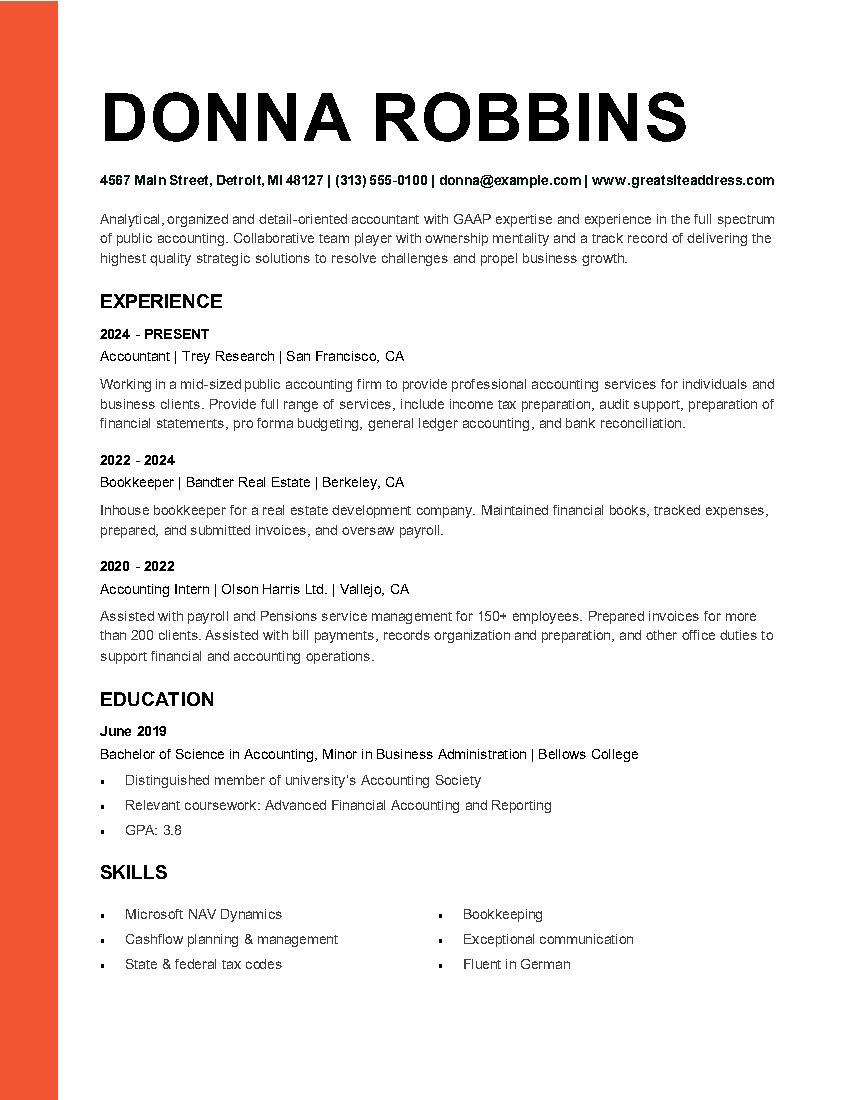

In [53]:
resume_data_vec, im = vectorize_resume()
im

In [55]:
resume_data_vec

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_299,width,height,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,original_word
0,-0.487900,0.069221,0.221830,0.266330,0.114560,0.377930,0.997770,-0.098329,-0.065525,0.019175,...,-0.411690,181.006225,48.025,72.0750,111.55525,253.081225,63.53025,16.0,48.025,DONNA
1,-0.331480,0.660450,0.398440,0.307320,0.032149,0.345830,0.142790,-0.348760,0.766100,-0.168600,...,-0.277320,228.695050,48.025,267.2700,111.55525,495.965050,63.53025,16.0,48.025,ROBBINS
2,0.049935,-0.096466,-0.273150,-0.243580,0.136660,-0.044576,-0.382560,0.138110,0.667570,-1.229400,...,0.010549,21.858600,10.200,72.0750,135.44200,93.933600,125.24200,17.0,10.200,4567
3,0.237490,0.133610,-0.093727,0.440170,0.052720,0.099604,-0.228480,-0.142400,0.044628,1.931000,...,0.074287,23.021400,10.200,96.6468,135.44200,119.668200,125.24200,17.0,10.200,Main
4,0.309249,0.354291,-0.133475,-0.179407,0.272835,0.293270,-0.096508,-0.148559,-0.464475,2.270300,...,0.330060,31.599600,10.200,121.8306,135.44200,153.430200,125.24200,17.0,10.200,"Street,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,-0.244260,0.386740,-0.091107,-0.104470,-0.275190,0.131600,-0.009528,-0.238310,0.076914,1.887100,...,0.243940,67.993200,10.200,388.4204,681.87200,456.413600,671.67200,2.0,10.200,communication
241,-0.410340,0.672390,0.122260,0.326450,-0.282560,-0.084786,0.012697,-0.087197,-0.049720,0.623550,...,-0.222980,3.588000,7.800,315.3000,699.40980,318.888000,691.60980,-1.0,7.800,•
242,-0.066420,-0.335610,-0.443900,0.878220,0.701120,0.257070,0.798790,-0.253790,-0.022371,1.161500,...,0.012465,27.407400,10.200,333.3200,699.86700,360.727400,689.66700,2.0,10.200,Fluent
243,0.089187,0.257920,0.262820,-0.029365,0.471870,-0.103890,-0.100130,0.081230,0.208830,2.572600,...,0.265010,8.058000,10.200,363.8690,699.86700,371.927000,689.66700,2.0,10.200,in


### Train RandomForestClassifier For Resume Title Classification
Training is currently performed through a custom made database of extracted words from multiple resumes

In [57]:
X_train = data.iloc[:, :-1]
y_train = data.iloc[:, -1]

In [61]:
rf = RandomForestClassifier()

In [63]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [64]:
filename = 'models/resume_rf_title_classifier.joblib'

joblib.dump(rf, filename)

['models/resume_rf_title_classifier.joblib']

In [65]:
y_pred = rf.predict(resume_data_vec.iloc[:, :-1])

In [66]:
y_pred

array([1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5], dtype=int64)

In [71]:
filename = 'models/resume_label_encoder.pkl'

resume_label_encoder = joblib.load(filename)

In [77]:
y_pred_df = pd.DataFrame(y_pred, columns=['label'])
decoded_labels = resume_label_encoder.inverse_transform(y_pred_df)['label'].values

In [79]:
decoded_labels

array(['PERSONAL', 'PERSONAL', nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, 'EXPERIENCE', nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

### Extract Titles Found (Experience, Skills, Education, ect)
Collect the required information of each word classified as a title word

In [17]:
def get_cluster_centers(y_pred: int, resume_data: object) -> None:
    original_words = resume_data_vec.iloc[:, -1]
    cluster_count = 1
    clusters = {1:[], # Filler
                2:[], # Education
                3:[], # Experience
                4:[]} # Skills
    print('--Words Identified As Title--')
    i = 0
    for pred in y_pred:
        if pred != 0:
            print(f'{original_words[i]}')
            clusters[pred].append(((resume_data.iloc[i]['left_distance'] + resume_data.iloc[i]['right_distance']) / 2, 
                                       (resume_data.iloc[i]['bottom_distance'] + resume_data.iloc[i]['top_distance']) / 2))
            cluster_count += 1
        i += 1
    return clusters

In [18]:
clusters = get_cluster_centers(y_pred, resume_data_vec)

--Words Identified As Title--
DONNA
ROBBINS
EXPERIENCE
EDUCATION
SKILLS


In [19]:
clusters

{1: [(162.5781125, 87.54275000000001), (381.617525, 87.54275000000001)],
 2: [(113.32319999999999, 503.99800000000005)],
 3: [(116.30440000000002, 217.57800000000003)],
 4: [(96.4665, 628.868)]}

### Cluster Text To Respective Titles
Assign each word to the closest title position. This process identifies what words are under what titles

In [21]:
# Calculate word center pos for custering
resume_data_vec['center_x'] = (resume_data_vec['left_distance'] + resume_data_vec['right_distance']) / 2
resume_data_vec['center_y'] = (resume_data_vec['bottom_distance'] + resume_data_vec['top_distance']) / 2

In [22]:
resume_data_vec

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,height,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,original_word,center_x,center_y
0,-0.487900,0.069221,0.221830,0.266330,0.114560,0.377930,0.997770,-0.098329,-0.065525,0.019175,...,48.025,72.0750,111.55525,253.081225,63.53025,16.0,48.025,DONNA,162.578113,87.54275
1,-0.331480,0.660450,0.398440,0.307320,0.032149,0.345830,0.142790,-0.348760,0.766100,-0.168600,...,48.025,267.2700,111.55525,495.965050,63.53025,16.0,48.025,ROBBINS,381.617525,87.54275
2,0.049935,-0.096466,-0.273150,-0.243580,0.136660,-0.044576,-0.382560,0.138110,0.667570,-1.229400,...,10.200,72.0750,135.44200,93.933600,125.24200,17.0,10.200,4567,83.004300,130.34200
3,0.237490,0.133610,-0.093727,0.440170,0.052720,0.099604,-0.228480,-0.142400,0.044628,1.931000,...,10.200,96.6468,135.44200,119.668200,125.24200,17.0,10.200,Main,108.157500,130.34200
4,0.309249,0.354291,-0.133475,-0.179407,0.272835,0.293270,-0.096508,-0.148559,-0.464475,2.270300,...,10.200,121.8306,135.44200,153.430200,125.24200,17.0,10.200,"Street,",137.630400,130.34200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,-0.244260,0.386740,-0.091107,-0.104470,-0.275190,0.131600,-0.009528,-0.238310,0.076914,1.887100,...,10.200,388.4204,681.87200,456.413600,671.67200,2.0,10.200,communication,422.417000,676.77200
241,-0.410340,0.672390,0.122260,0.326450,-0.282560,-0.084786,0.012697,-0.087197,-0.049720,0.623550,...,7.800,315.3000,699.40980,318.888000,691.60980,-1.0,7.800,•,317.094000,695.50980
242,-0.066420,-0.335610,-0.443900,0.878220,0.701120,0.257070,0.798790,-0.253790,-0.022371,1.161500,...,10.200,333.3200,699.86700,360.727400,689.66700,2.0,10.200,Fluent,347.023700,694.76700
243,0.089187,0.257920,0.262820,-0.029365,0.471870,-0.103890,-0.100130,0.081230,0.208830,2.572600,...,10.200,363.8690,699.86700,371.927000,689.66700,2.0,10.200,in,367.898000,694.76700


In [23]:
##---Combine close clusters to eachother of the same category---##
def combine_close_cluster_titles(clusters, threshold=250):
    new_clusters = {1:[], # Filler
                    2:[], # Education
                    3:[], # Experience
                    4:[]} # Skills
    clusters_to_skip = []
    for index, cluster_arr in clusters.items():
        # Check if more titles exist for this category
        if len(cluster_arr) > 1:
            for i in cluster_arr:
                closest_index_to_i_val = float('inf')
                closest_index_to_i_pos = None
                # Skip if i has already combined previously
                if i in clusters_to_skip:
                    continue
                else:
                    for j in cluster_arr:
                        # Prevent combining same cluster
                        if i == j:
                            continue
                        else:
                            # Calculate distance from title i and j
                            current_euclidean_distance = math.sqrt((i[0] - j[0])**2 + ((i[1] - j[1])*3.5)**2)
                            # Store results of closest title to title i
                            if current_euclidean_distance < closest_index_to_i_val:
                                closest_index_to_i_val = current_euclidean_distance
                                closest_index_to_i_pos = j
 
                if closest_index_to_i_val < threshold:
                    # Add new cluster 
                    new_clusters[index].append(((i[0] + closest_index_to_i_pos[0]) / 2, (i[1] + closest_index_to_i_pos[1]) / 2))
                    # Prevent combining j in future loops
                    clusters_to_skip.append(closest_index_to_i_pos)
                else:
                    new_clusters[index].append(i)
        else:
            new_clusters[index] = cluster_arr
    return new_clusters

In [24]:
new_clusters = combine_close_cluster_titles(clusters)

In [25]:
new_clusters

{1: [(272.09781875, 87.54275000000001)],
 2: [(113.32319999999999, 503.99800000000005)],
 3: [(116.30440000000002, 217.57800000000003)],
 4: [(96.4665, 628.868)]}

In [26]:
##---Cluster each word to their closest title by their y-axis and assigning it's id to respective word---##
def cluster_text(clusters, data):
    clustered_data = []

    for row in data.values:
        smallest_distance = float('inf')
        closest_cluster = None

        for value, cluster_arr in clusters.items():
            word_y = row[-1]
            
            for cluster in cluster_arr:
                cluster_y = cluster[1]
                
                # Check if word is below cluster
                if cluster_y <= word_y:
                    # Calculate distance
                    y_distance = word_y - cluster_y
                    # Store results of closest title to word
                    if y_distance < smallest_distance:
                        smallest_distance = y_distance
                        closest_cluster = value
                        
        # Append closest cluster for this word
        clustered_data.append(closest_cluster)
        
    data['cluster'] = clustered_data
            
    return data

In [27]:
resume_data_vec = cluster_text(new_clusters, resume_data_vec)

In [28]:
resume_data_vec

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,original_word,center_x,center_y,cluster
0,-0.487900,0.069221,0.221830,0.266330,0.114560,0.377930,0.997770,-0.098329,-0.065525,0.019175,...,72.0750,111.55525,253.081225,63.53025,16.0,48.025,DONNA,162.578113,87.54275,1
1,-0.331480,0.660450,0.398440,0.307320,0.032149,0.345830,0.142790,-0.348760,0.766100,-0.168600,...,267.2700,111.55525,495.965050,63.53025,16.0,48.025,ROBBINS,381.617525,87.54275,1
2,0.049935,-0.096466,-0.273150,-0.243580,0.136660,-0.044576,-0.382560,0.138110,0.667570,-1.229400,...,72.0750,135.44200,93.933600,125.24200,17.0,10.200,4567,83.004300,130.34200,1
3,0.237490,0.133610,-0.093727,0.440170,0.052720,0.099604,-0.228480,-0.142400,0.044628,1.931000,...,96.6468,135.44200,119.668200,125.24200,17.0,10.200,Main,108.157500,130.34200,1
4,0.309249,0.354291,-0.133475,-0.179407,0.272835,0.293270,-0.096508,-0.148559,-0.464475,2.270300,...,121.8306,135.44200,153.430200,125.24200,17.0,10.200,"Street,",137.630400,130.34200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,-0.244260,0.386740,-0.091107,-0.104470,-0.275190,0.131600,-0.009528,-0.238310,0.076914,1.887100,...,388.4204,681.87200,456.413600,671.67200,2.0,10.200,communication,422.417000,676.77200,4
241,-0.410340,0.672390,0.122260,0.326450,-0.282560,-0.084786,0.012697,-0.087197,-0.049720,0.623550,...,315.3000,699.40980,318.888000,691.60980,-1.0,7.800,•,317.094000,695.50980,4
242,-0.066420,-0.335610,-0.443900,0.878220,0.701120,0.257070,0.798790,-0.253790,-0.022371,1.161500,...,333.3200,699.86700,360.727400,689.66700,2.0,10.200,Fluent,347.023700,694.76700,4
243,0.089187,0.257920,0.262820,-0.029365,0.471870,-0.103890,-0.100130,0.081230,0.208830,2.572600,...,363.8690,699.86700,371.927000,689.66700,2.0,10.200,in,367.898000,694.76700,4


### Segmentation
Combine each word in the dataframe to rebuild the pharagraphs and sections from the resume broken up into their respective sections. Then contextually segment or split on rules, each section.

In [30]:
sections = {cluster: '' for cluster in new_clusters}

for _, row in resume_data_vec.iterrows():
    sections[row["cluster"]] += row["original_word"] + " "

sections

{1: 'DONNA ROBBINS 4567 Main Street, Detroit, MI 48127 | (313) 555-0100 | donna@example.com | www.greatsiteaddress.com Analytical, organized and detail-oriented accountant with GAAP expertise and experience in the full spectrum of public accounting. Collaborative team player with ownership mentality and a track record of delivering the highest quality strategic solutions to resolve challenges and propel business growth. ',
 2: 'EDUCATION June 2019 Bachelor of Science in Accounting, Minor in Business Administration | Bellows College • Distinguished member of university’s Accounting Society • Relevant coursework: Advanced Financial Accounting and Reporting • GPA: 3.8 ',
 3: 'EXPERIENCE 2024 - PRESENT Accountant | Trey Research | San Francisco, CA Working in a mid-sized public accounting firm to provide professional accounting services for individuals and business clients. Provide full range of services, include income tax preparation, audit support, preparation of financial statements, p

In [31]:
sections

{1: 'DONNA ROBBINS 4567 Main Street, Detroit, MI 48127 | (313) 555-0100 | donna@example.com | www.greatsiteaddress.com Analytical, organized and detail-oriented accountant with GAAP expertise and experience in the full spectrum of public accounting. Collaborative team player with ownership mentality and a track record of delivering the highest quality strategic solutions to resolve challenges and propel business growth. ',
 2: 'EDUCATION June 2019 Bachelor of Science in Accounting, Minor in Business Administration | Bellows College • Distinguished member of university’s Accounting Society • Relevant coursework: Advanced Financial Accounting and Reporting • GPA: 3.8 ',
 3: 'EXPERIENCE 2024 - PRESENT Accountant | Trey Research | San Francisco, CA Working in a mid-sized public accounting firm to provide professional accounting services for individuals and business clients. Provide full range of services, include income tax preparation, audit support, preparation of financial statements, p

In [32]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.embeddings import HuggingFaceEmbeddings

In [33]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

text_splitter = SemanticChunker(
    embeddings=embeddings,
    breakpoint_threshold_type="percentile"
)

segmented_sections = {}
for section, text in sections.items():
    # Contextually segment non-skill text
    if section != 4:
        chunks = text_splitter.create_documents([text])
        segmented_sections[section] = [chunk.page_content for chunk in chunks if chunk.page_content.strip()]
    # Segment skills by rules
    else:
        skills = re.split(r"\s*[•|\n]\s*", text)
        segmented_sections[section] = [s.strip() for s in skills if len(s.strip()) > 2]

segmented_sections

C:\Users\yanni\AppData\Local\Temp\ipykernel_23396\3901030196.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


ImportError: Could not import sentence_transformers python package. Please install it with `pip install sentence-transformers`.

### Contextually Embed Each Segmentation
Embed information for comparison with job listing embeddings

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
# Function to get BERT embeddings
def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
# Generate embeddings for each segmentation
embedded_sections = {}
for section, texts in segmented_sections.items():
    embedded_sections[section] = np.array([get_bert_embedding(text, tokenizer, model) 
                                           for text in texts]
    )

In [ ]:
embedded_sections